In [62]:
from bioservices import UniProt
import regex as re
import io
import pandas as pd
import mdtraj as md
import matplotlib.pyplot as plt
from contact_map import ContactFrequency, ContactDifference

In [63]:
protein_code = 'A6NDD5'

In [64]:
u = UniProt(verbose=False)

gff = u.search('accession:%s'%protein_code, frmt='gff')
fasta = u.search('accession:%s'%protein_code, frmt='fasta')
print(fasta)
searchlines = io.StringIO(gff)
gff_df = pd.read_csv(
    searchlines, 
    sep="\t", 
    header=None,
    comment="#", 
    names=("seqname", "source", "feature", "start",
           "end", "score", "strand", "frame", "attribute", 'other'),
)

gff_df_attrib = gff_df['attribute'].str.split(pat=";",expand=True)
gff_df_full = pd.concat([gff_df.drop(columns=['attribute', 'other']), gff_df_attrib],axis=1)
fast_seq = u.get_fasta_sequence(protein_code)

>sp|A6NDD5|SYN1L_HUMAN Synapse differentiation-inducing gene protein 1-like OS=Homo sapiens OX=9606 GN=SYNDIG1L PE=3 SV=1
MESLSELQNPLLPRSPAHLHGPYPYPETPPSWSCQEKLYSYLLGGAGPAGAHQLLDPGSL
QLAVEAWYRPSCLLGRDKVKEPRAGSCETSFTEDREPQEGPPEQPTGPGQAAENVTIQTV
SYGVQEELRDQEDDQEEEESDATSTESESEDNFLTLPPRDHLGLTLFSMLCCFWPLGIAA
FYFSQGTSKAISKGDFRLASTTSRRALFLATLAIAVGAGLYVAVVVALAAYMSQNGHG



In [65]:
gff_df['attribute']

0     ID=PRO_0000332725;Note=Synapse differentiation...
1     Note=Extracellular;Ontology_term=ECO:0000255;e...
2     Note=Helical;Ontology_term=ECO:0000255;evidenc...
3     Note=Cytoplasmic;Ontology_term=ECO:0000255;evi...
4     Note=Helical;Ontology_term=ECO:0000255;evidenc...
5     Note=Extracellular;Ontology_term=ECO:0000255;e...
6     Note=Disordered;Ontology_term=ECO:0000256;evid...
7     Note=Disordered;Ontology_term=ECO:0000256;evid...
8     Note=Disordered;Ontology_term=ECO:0000256;evid...
9     Note=Basic and acidic residues;Ontology_term=E...
10    Note=Acidic residues;Ontology_term=ECO:0000256...
Name: attribute, dtype: object

In [66]:
import re
gff_df['Note'] = gff_df['attribute'].str.extract(r'Note\=(.*?)\;')
gff_df['Ontology_term'] = gff_df['attribute'].str.extract(r'Ontology_term\=(.*?)\;')
gff_df['Evidence'] = gff_df['attribute'].str.extract(r'evidence\=(.*?)\;')
gff_df.drop(columns=['attribute', 'other'],inplace=True)
gff_df

,seqname,source,feature,start,end,score,strand,frame,Note,Ontology_term,Evidence
0,A6NDD5,UniProtKB,Chain,1,238,.,.,.,NaN,NaN,NaN
1,A6NDD5,UniProtKB,Topological domain,1,162,.,.,.,Extracellular,ECO:0000255,NaN
2,A6NDD5,UniProtKB,Transmembrane,163,183,.,.,.,Helical,ECO:0000255,NaN
3,A6NDD5,UniProtKB,Topological domain,184,205,.,.,.,Cytoplasmic,ECO:0000255,NaN
4,A6NDD5,UniProtKB,Transmembrane,206,226,.,.,.,Helical,ECO:0000255,NaN
5,A6NDD5,UniProtKB,Topological domain,227,238,.,.,.,Extracellular,ECO:0000255,NaN
6,A6NDD5,UniProtKB,Region,1,29,.,.,.,Disordered,ECO:0000256,NaN
7,A6NDD5,UniProtKB,Region,83,111,.,.,.,Disordered,ECO:0000256,NaN
8,A6NDD5,UniProtKB,Region,127,154,.,.,.,Disordered,ECO:0000256,NaN
9,A6NDD5,UniProtKB,Compositional bias,83,100,.,.,.,Basic and acidic residues,ECO:0000256,NaN


In [67]:
gff_df['feature'].str.contains('Transmembrane').any()


True

In [68]:
gff_df[gff_df['feature']=='Transmembrane']['Evidence']

2    NaN
4    NaN
Name: Evidence, dtype: object

In [69]:
gff_df[gff_df['feature']=='Transmembrane']['Evidence'].any()


False

c:\tools\miniconda3\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


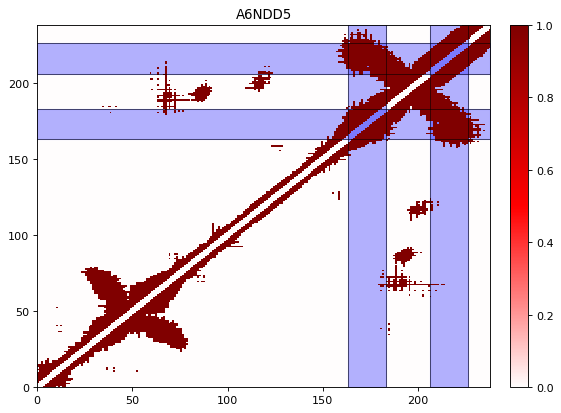

In [70]:


EphrinB2_pdb = md.load_pdb('./afdb_homo_sapiens/AF-%s-F1-model_v2.pdb'%protein_code)
gff_trans_loc = gff_df_full[gff_df_full['feature'] == 'Transmembrane'][['start','end']]

traj_contacts  = ContactFrequency(EphrinB2_pdb,cutoff=2.0)
fig, ax = traj_contacts.residue_contacts.plot(figsize=(8, 6), dpi=80);
plt.title('%s'%protein_code)

for i in range(len(gff_trans_loc)):
    start=gff_trans_loc['start'].iloc[i]
    end=gff_trans_loc['end'].iloc[i]

    ax.axvline(start, color='k', lw=0.5)
    ax.axvline(end, color='k', lw=0.5)
    ax.fill_betweenx((0,len(traj_contacts.residue_contacts.df)),start,end,color='blue',alpha=0.3)
    ax.axhline(start, color='k', lw=0.5)
    ax.axhline(end, color='k', lw=0.5)
    ax.fill_between((0,len(traj_contacts.residue_contacts.df)),start,end,color='blue',alpha=0.3)
fig.savefig('./plot_contact_map/%s'%protein_code) 


In [71]:
gff_trans_loc

,start,end
2,163,183
4,206,226


In [74]:
for i in range(len(gff_trans_loc)):
    try:
        outside_regions = (gff_trans_loc['end'].iloc[i], gff_trans_loc['start'].iloc[i+1])
    except:
        outside_regions = (gff_trans_loc['end'].iloc[i],len(fast_seq))
    print(outside_regions)

(183, 206)
(226, 238)


In [ ]:
for i in range(len(gff_trans_loc)):
    try:
        inside_regions = (gff_trans_loc['end'].iloc[i], gff_trans_loc['start'].iloc[i+1])
    except:
        inside_regions = (gff_trans_loc['end'].iloc[i],len(fast_seq))
    print(outside_regions)